**Table of contents**<a id='toc0_'></a>    
- 1. [Alaska overview  ](#toc1_)    
- 2. [Load data ](#toc2_)    
  - 2.1. [Download earthquake catalog (USGS)](#toc2_1_)    
  - 2.2. [Load tremor data (Wech) ](#toc2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Alaska overview   [&#128285;](#toc0_)

In [114]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load data  [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Download earthquake catalog (USGS) [&#128285;](#toc0_)

In [115]:
# Load earthquake catalog
path = workdir + 'projects/data/Catalogs/alaska_earthquakes/ak_eq_anss_0113_0116.csv'
eq = pd.read_csv(path, skiprows=1, parse_dates=['time'])

# Rename columns
eq.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'time': 'date'}, inplace=True)

# Sort by date
eq.sort_values('date', inplace=True)

# Keep only data that we are using
eq.drop(['magType', 'nst', 'dmin', 'rms', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource', 'net', 'gap', 'id'], axis=1, inplace=True)

## 2.2. <a id='toc2_2_'></a>Load tremor data (Wech)  [&#128285;](#toc0_)

In [116]:
# Load data
path = workdir + 'projects/data/Catalogs/alaska_wech16_0815/AK_tremor.txt'
trm = pd.read_csv(path, delimiter='\t', skiprows=1, names=['date', 'lon', 'lat'])

trm['date'] = pd.to_datetime(trm['date'])

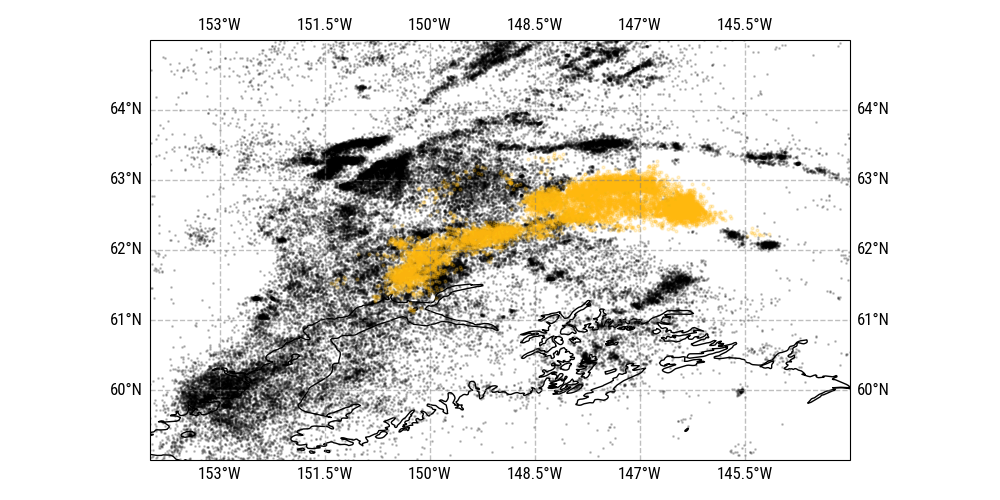

In [137]:
# A map of it
fig = plt.figure(figsize=(10, 5))

dlon = (trm.lon.max() - trm.lon.min())
dlat = (trm.lat.max() - trm.lat.min())
minlon = -154
maxlon= -144
minlat = 59
maxlat = 65

extent = [minlon, maxlon, minlat, maxlat]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

ax.plot(eq.lon, eq.lat, 'o', c=to_rgba('k', .2), ms=1, transform=ccrs.PlateCarree())
ax.plot(trm.lon, trm.lat, 'o', c=to_rgba('C2', .2), ms=2, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=-1)

ax.set_extent(extent)

plt.tight_layout()
plt.show()

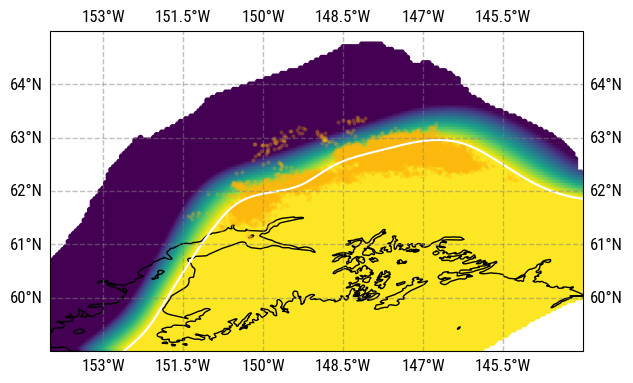

In [209]:
# Project tremor on depth
# --> Load slab (better slab Jadamec and Billen 2012 or Slab2? Slab2 better represents top of slab compared to seismicity)
path = workdir + 'projects/data/Slabs/alaska/slab2/alu_slab2_dep_02.23.18.xyz'
slab = pd.read_csv(path, names=['lon', 'lat', 'depth'])
slab.lon = slab.lon - 360

# --> Load slab contours
path = workdir + "projects/data/Slabs/alaska/slab2/alu_slab2_dep_02.23.18_contours.in"

contours = {}
with open(path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line[0] == '>':
            key = float(line.split()[1])
            contours[key] = {'lon': [], 'lat': []}
        else:
            contours[key]['lon'].append(float(line.split()[0]))
            contours[key]['lat'].append(float(line.split()[1]))

# --> Trim (boundaries of map)
slab = slab[(slab.lon > minlon) & (slab.lon < maxlon) & (slab.lat > minlat) & (slab.lat < maxlat)]

# --> Project tremor on depth (find nearest point horizontally)
crs = ccrs.TransverseMercator(central_latitude=trm.lat.values.mean(), central_longitude=trm.lon.values.mean())
coord_trm = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
coord_slab = crs.transform_points(ccrs.PlateCarree(), slab.lon.values, slab.lat.values)

from scipy.spatial import cKDTree
tree_slab = cKDTree(coord_slab[:, :2])

dist, ind = tree_slab.query(coord_trm[:, :2], k=1)
trm['depth'] = -slab.depth.values[ind]

# --> Find distance from slab for earthquakes
coord_eq = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

dist, ind = tree_slab.query(coord_eq[:, :2], k=1)
eq['dz_from_slab'] = -slab.depth.values[ind] - eq.depth.values

# Compare depths
fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.plot(trm.lon, trm.lat, 'o', c=to_rgba('C2', .2), ms=2, transform=ccrs.PlateCarree())
ax.plot(contours[-40]['lon'], contours[-40]['lat'], c='w', transform=ccrs.PlateCarree())
ax.scatter(slab.lon, slab.lat, c=slab.depth, s=10, transform=ccrs.PlateCarree(), cmap='viridis', vmin=-60, vmax=-40)

ax.set_extent(extent)

# ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=-1)

plt.tight_layout()
plt.show()

In [221]:
# Project along-strike
# --> Cartesian coordinates
trm.loc[:, 'x'] = coord_trm[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = coord_trm[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = coord_eq[:, 0]/1000
eq.loc[:, 'y'] = coord_eq[:, 1]/1000

# --> Fit a polynomial to the tremor line
p_strike = np.polyfit(trm.x, trm.y, 2)

# --> Define strike line
x0 = -200
y0 = np.polyval(p_strike, x0)
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
x = x0
while x < 150:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
    x += dx
    y = np.polyval(p_strike, x)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Project, or find the nearest point on the line
tree_strike = cKDTree(np.column_stack([X, Y]))


eq_across_strike_dist, eq_nearest_idx = tree_strike.query(np.column_stack((eq.x, eq.y)))
trm_across_strike_dist, trm_nearest_idx = tree_strike.query(np.column_stack((trm.x, trm.y)))

eq_along_strike_dist = S[eq_nearest_idx]
trm_along_strike_dist = S[trm_nearest_idx]

eq['xf'] = eq_along_strike_dist  # xf or xfault: along-strike distance in km
eq['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km
trm['xf'] = trm_along_strike_dist
trm['yf'] = trm_across_strike_dist

# # Show
# fig, axes = plt.subplots(1, 2, figsize=(10, 10))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('y (km)')  
#     ax.set_ylabel('x (km)')
#     ax.plot(X, Y, 'r', zorder=10)

# axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, cmap='viridis', vmin=0, vmax=400)
# axes[0].scatter(trm.x, trm.y, s=3, c='k', cmap='viridis', vmin=0, vmax=1500)
# axes[0].scatter(trm.x, trm.y, s=1, c=trm_along_strike_dist, cmap='viridis', vmin=0, vmax=400)

# axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, cmap='viridis', vmin=0, vmax=200)
# axes[1].scatter(trm.x, trm.y, s=3, c='k')
# axes[1].scatter(trm.x, trm.y, s=1, c=trm_across_strike_dist, cmap='viridis', vmin=0, vmax=200)

# plt.tight_layout()
# plt.show()


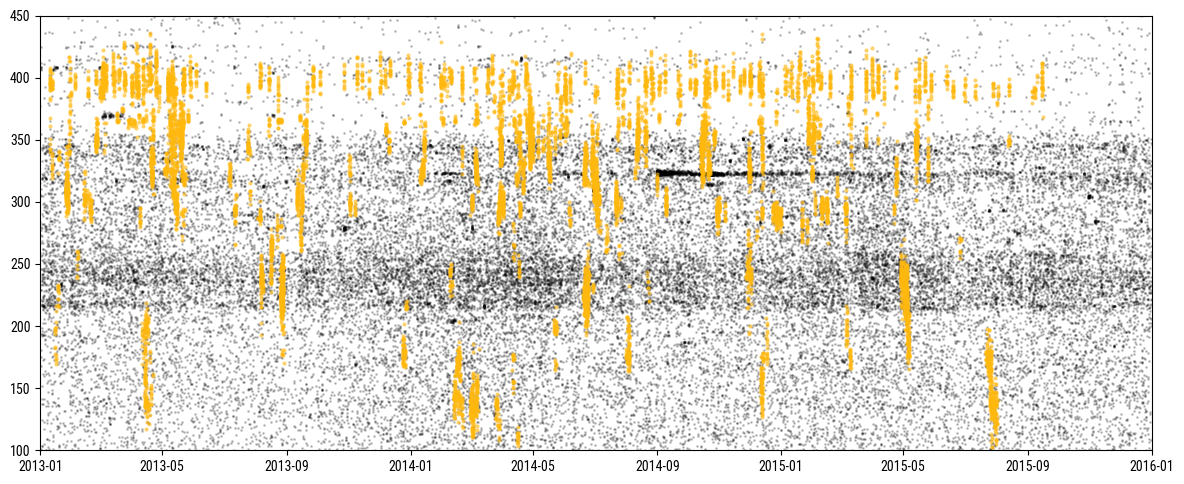

In [232]:
# Show what it looks like
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2016-01-01')) 
ax.set_ylim(100, 450)
ax.plot(eq.date, eq.xf, 'o', c=to_rgba('k', .2), ms=1)
ax.plot(trm.date, trm.xf, 'o', c=to_rgba('C2', .5), ms=2)
plt.tight_layout()
plt.show()

# Count number of earthquakes that can trigger tremor

In [223]:
epicentral = False

In [263]:
# Which earthquakes
interval = [np.datetime64('2013-01-01'), np.datetime64('2016-01-01')]
min_mag = 2.0
selected_eq = eq[(eq.date.values >= interval[0]) & (eq.date.values <= interval[1]) & (eq.mag >= min_mag)].copy()
print(f"Selected {len(selected_eq)} earthquakes")

Selected 7968 earthquakes


In [264]:
# Count number of earthquakes at distance (ball-tree counting, approximate but fast)
dists = [10, 20, 30, 50, 100]

n_eq = np.zeros((len(dists), len(trm)))   # number of earthquakes at given distance of each tremor event
eq_at_dist = np.zeros((len(dists), len(selected_eq))).astype(bool)  # boolean array to keep track of which earthquakes are within given distance from any tremor

# Build K-D trees
if epicentral:
    eq_tree = cKDTree(selected_eq[['x', 'y']].values)
    trm_tree = cKDTree(trm[['x', 'y']].values)
else:
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)

# Look for pairs of earthquakes and tremors within distance
for jj, dist in enumerate(dists):
    # Find earthquakes within distance of tremors
    eq_idx = trm_tree.query_ball_tree(eq_tree, dist)
    
    # --> How earthquakes at distance from tremor
    n_eq[jj, :] = np.array([len(e) for e in eq_idx])
    
    # --> Which ones
    eq_at_dist_idx = np.concatenate(eq_idx)
    eq_at_dist_idx = np.unique(eq_at_dist_idx).astype(int)
    eq_at_dist[jj, eq_at_dist_idx] = True

# Convert counts to rates per year
n_eq = n_eq / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

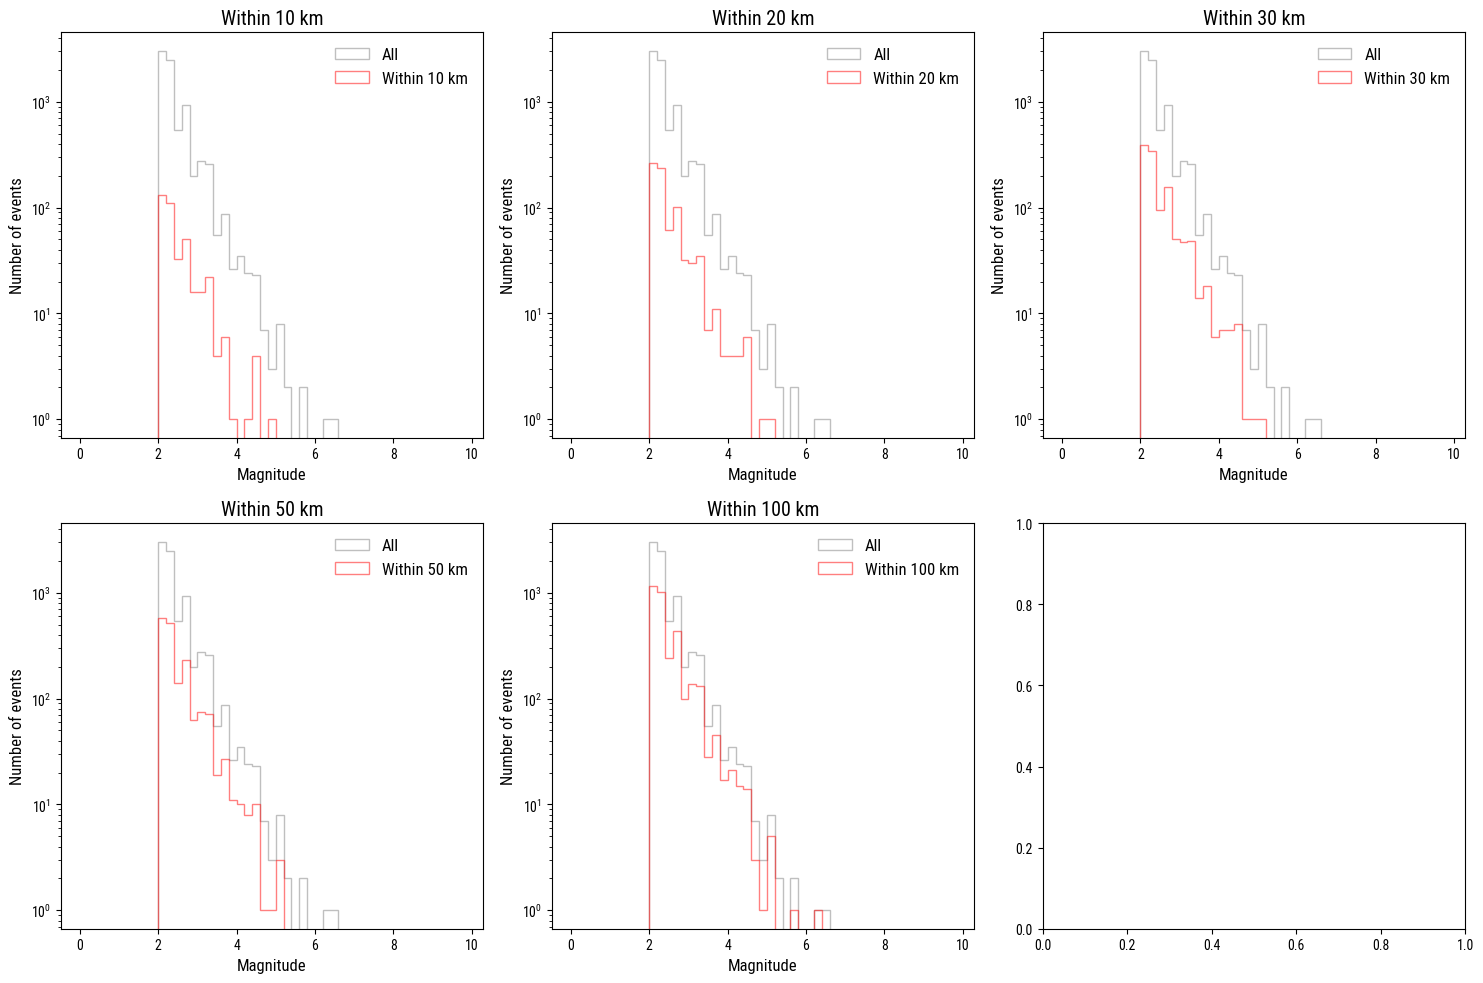

In [265]:
# Magnitude of completeness of each group
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for jj, dist in enumerate(dists):
    ax = axes.flat[jj]
    ax.hist(selected_eq.mag.values, bins=np.arange(0, 10, .2), color='gray', alpha=.5, label='All', histtype='step', zorder=0)
    ax.hist(selected_eq.mag.values[eq_at_dist[jj]], bins=np.arange(0, 10, .2), color='red', alpha=.5, label='Within {:d} km'.format(dist), histtype='step', zorder=1)
    ax.set_title('Within {:d} km'.format(dist))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of events')
    ax.set_yscale('log')
    ax.legend()
    
plt.tight_layout()
plt.show()

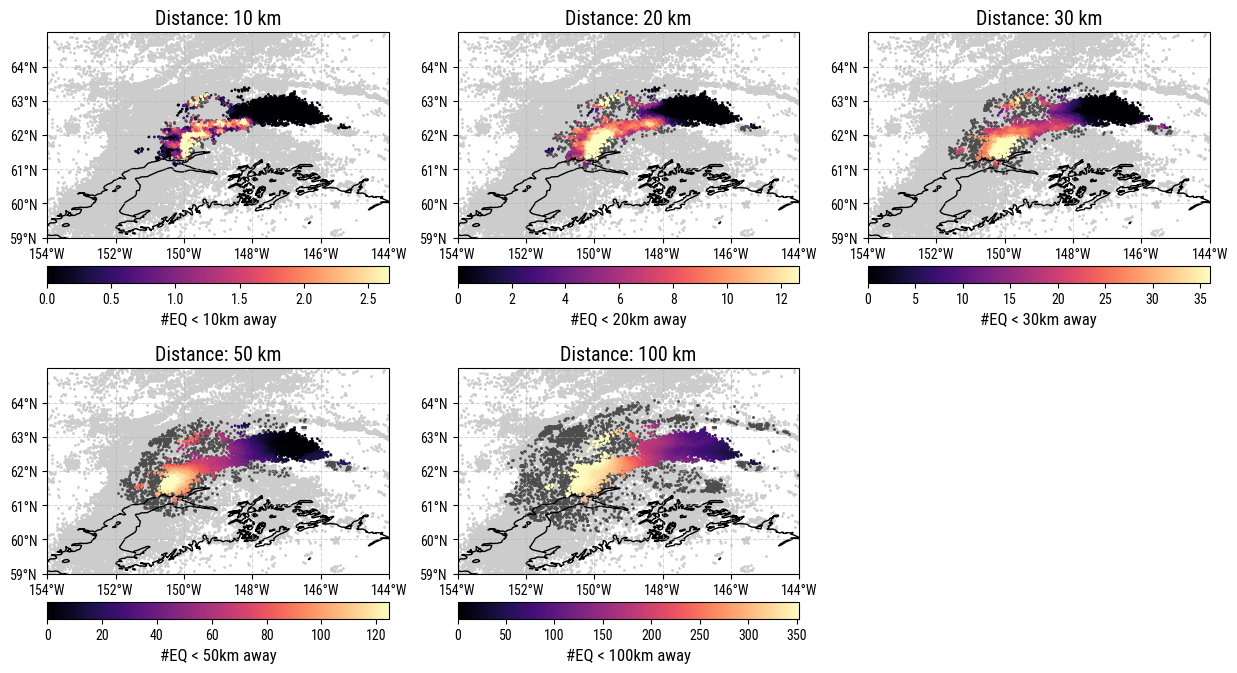

In [266]:
# Plot it
lon_min = minlon
lon_max = maxlon
lat_min = minlat
lat_max = maxlat
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(15, 8))
axes = [plt.subplot(2, 3, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(dists)), axes):
    ax.set_title('Distance: {:d} km'.format(dists[ii]))
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=n_eq[ii, :], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(n_eq[ii, :], 95), zorder=2, label='Tremor')
    ax.scatter(selected_eq.lon[eq_at_dist[ii]], selected_eq.lat[eq_at_dist[ii]], c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(dists[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    #ax.legend(loc='lower left', fontsize='small', framealpha=.5, scatterpoints=10, markerscale=3)

    # # Colorbar
    # x_min_ax = 0.5; y_min_ax = 0.3
    # w_ax = 0.45; h_ax = 0.05
    # x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    # x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    # x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    # h_fig = y_max_fig - y_min_fig
    # w_fig = x_max_fig - x_min_fig

    # cb = fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    # cbar = plt.colorbar(sc, cax=cb, orientation='horizontal', label="#EQ < {:d}km away".format(dists[ii]))
    plt.colorbar(sc, orientation='horizontal', label="#EQ < {:d}km away".format(dists[ii]), pad=0.1, fraction=0.07)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

# plt.tight_layout()
plt.show()

In [267]:
# Save it
trm.loc[:, 'n_eq_10km'] = n_eq[0, :]
trm.loc[:, 'n_eq_20km'] = n_eq[1, :]
trm.loc[:, 'n_eq_30km'] = n_eq[2, :]    
trm.loc[:, 'n_eq_50km'] = n_eq[3, :]
trm.loc[:, 'n_eq_100km'] = n_eq[4, :]

trm.to_csv('data/alaska/processed/alaska_trm_0113_0116_slab2_eqdist_mc{:.1f}.csv'.format(min_mag), index=False)

# Save the earthquakes
selected_eq.loc[:, 'in10km'] = eq_at_dist[0, :]
selected_eq.loc[:, 'in20km'] = eq_at_dist[1, :]
selected_eq.loc[:, 'in30km'] = eq_at_dist[2, :]
selected_eq.loc[:, 'in50km'] = eq_at_dist[3, :]
selected_eq.loc[:, 'in100km'] = eq_at_dist[4, :]

selected_eq.to_csv('data/alaska/processed/alaska_eqmc{:.1f}_0113_0116_eqdist.csv'.format(min_mag), index=False)